# 1. Setup

In [ ]:
# Standard library
import numpy as np
import pandas as pd
from pathlib import Path

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration and utilities
import tomllib
from rich import print

# Set random seed for reproducibility
np.random.seed(42)

In [770]:
# Load configuration
with open('config.toml', 'rb') as f:
    config = tomllib.load(f)

print("✅ Configuration loaded")

# Load dataset
dataset_path = Path('datasets/dataset_raw.csv')
df = pd.read_csv(dataset_path, delimiter=';')

# Normalise column names to snake_case
df.columns = [col.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') 
              for col in df.columns]

print(f"📊 Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]:,} columns")

# Create binary target (0=Dropout, 1=Continue)
df['target_binary'] = df['target'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 1})

# Remove second semester features (data leakage prevention)
second_sem_cols = [col for col in df.columns if '2nd_sem' in col]
df = df.drop(columns=second_sem_cols)

print(f" - Removed {len(second_sem_cols)} second semester features to prevent data leakage")
print(f" - Final dataset: {df.shape[0]:,} rows × {df.shape[1]:,} columns")

✅ Configuration loaded

📊 Dataset loaded: 4,424 rows × 37 columns

- Removed 6 second semester features to prevent data leakage

- Final dataset: 4,424 rows × 32 columns

In [771]:
def normalise_column_names(df):
    """Normalise DataFrame column names to snake_case format"""
    def to_snake_case(name):
        # Convert to string, strip whitespace, lowercase
        name = str(name).strip().lower()
        # Replace spaces and apostrophes with underscores
        name = name.replace(' ', '_').replace("'", '')
        # Remove special characters
        name = name.replace('(', '').replace(')', '').replace('/', '_')
        name = name.replace('-', '_').replace('.', '_')
        # Clean up multiple underscores
        while '__' in name:
            name = name.replace('__', '_')
        # Remove trailing/leading underscores
        name = name.strip('_')
        return name
    
    df_copy = df.copy()
    df_copy.columns = [to_snake_case(col) for col in df_copy.columns]
    return df_copy

# Re-apply normalisation with apostrophe handling
df = normalise_column_names(df)
print('✅ Column names normalised (apostrophes removed)')


✅ Column names normalised (apostrophes removed)

# 2. Feature Selection

In [772]:
# Keep only selected features
selected_features = [
    'tuition_fees_up_to_date', 'scholarship_holder', 'application_order',
    'admission_grade', 'age_at_enrollment', 'curricular_units_1st_sem_grade'
]

# Add engineered features for parents background
df['parental_higher_education'] = (
    (df['mothers_qualification'].isin(config['parental_features']['higher_education_codes'])) |
    (df['fathers_qualification'].isin(config['parental_features']['higher_education_codes']))
).astype(int)

df['parental_professional_occupation'] = (
    (df['mothers_occupation'].isin(config['parental_features']['professional_occupation_codes'])) |
    (df['fathers_occupation'].isin(config['parental_features']['professional_occupation_codes']))
).astype(int)

selected_features.extend(['parental_higher_education', 'parental_professional_occupation'])

# Create final dataset with selected features
X = df[selected_features]
y = df['target_binary']

print(f'🎯 Selected {len(selected_features)} features for k-NN:')
for feature in selected_features:
    print(f'   • {feature}')

print(f'\n- Final dataset: {X.shape[0]:,} samples, {X.shape[1]} features')
print(f'- Target distribution: {y.value_counts().to_dict()}')

🎯 Selected 8 features for k-NN:

• tuition_fees_up_to_date

• scholarship_holder

• application_order

• admission_grade

• age_at_enrollment

• curricular_units_1st_sem_grade

• parental_higher_education

• parental_professional_occupation

- Final dataset: 4,424 samples, 8 features

- Target distribution: {1: 3003, 0: 1421}

# 3. Train Test Split

In [773]:
# Split the data using config parameters
train_size = config['k-NN_model']['train_size']
stratify_split = config['k-NN_model']['stratify']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=train_size,
    stratify=y if stratify_split else None,
    random_state=42
)

# Calculate percentages
train_pct = int(train_size * 100)
test_pct = 100 - train_pct

print(f'📊 Data split ({train_pct}/{test_pct}):')
print(f'   Training: {X_train.shape[0]:,} samples')
print(f'   Test: {X_test.shape[0]:,} samples')

print(f'\n🎯 Class distribution:')
print(f'   Training: {y_train.value_counts().to_dict()}')
print(f'   Test: {y_test.value_counts().to_dict()}')

# Verify class balance is maintained
train_ratio = y_train.mean()
test_ratio = y_test.mean()
print(f'\n✅ Continuation rate: Train={train_ratio:.3f}, Test={test_ratio:.3f}')

📊 Data split (80/20):

Training: 3,539 samples

Test: 885 samples

🎯 Class distribution:

Training: {1: 2402, 0: 1137}

Test: {1: 601, 0: 284}

✅ Continuation rate: Train=0.679, Test=0.679

# 4. Pipeline

In [774]:
# Define feature types for preprocessing
numeric_features = ['application_order', 'admission_grade', 'age_at_enrollment', 
                   'curricular_units_1st_sem_grade']
binary_features = ['tuition_fees_up_to_date', 'scholarship_holder', 
                  'parental_higher_education', 'parental_professional_occupation']

# Get scaler type from config
scaler_type = config['k-NN_model']['scaler_type']

if scaler_type == 'standard':
    scaler = StandardScaler()
elif scaler_type == 'minmax':
    scaler = MinMaxScaler()
else:
    raise ValueError(f'Unknown scaler type: {scaler_type}')

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numeric_features),
        ('bin', 'passthrough', binary_features)
    ],
    remainder='drop'
)

print(f'🔧 Preprocessing pipeline created:')
print(f'   Scaler: {scaler_type}')
print(f'   Numeric features ({len(numeric_features)}): {numeric_features}')
print(f'   Binary features ({len(binary_features)}): {binary_features}')

🔧 Preprocessing pipeline created:

Scaler: minmax

Numeric features (4): ['application_order', 'admission_grade', 'age_at_enrollment', 
'curricular_units_1st_sem_grade']

Binary features (4): ['tuition_fees_up_to_date', 'scholarship_holder', 'parental_higher_education', 
'parental_professional_occupation']

# 5. Model Training

In [775]:
# Get hyperparameter range from config
k_range = range(config['k-NN_model']['n_neighbors_range'][0], 
                config['k-NN_model']['n_neighbors_range'][1] + 1, 2)
cv_folds = config['k-NN_model']['cv']

# Create pipeline with preprocessing and k-NN
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'classifier__n_neighbors': k_range,
    'classifier__weights': ['uniform', 'distance']
}

# Create custom scorer for withdrawal recall (specificity)
def withdrawal_recall(y_true, y_pred):
    """Calculate recall for withdrawal class (class 0)"""
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0] < 2:
        return 0.0
    return cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0.0

withdrawal_scorer = make_scorer(withdrawal_recall)

# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
    scoring=withdrawal_scorer,
    n_jobs=-1,
    verbose=1
)

print(f'🔍 Starting grid search:')
print(f'   k-values: {list(k_range)}')
print(f'   Weights: {param_grid["classifier__weights"]}')
print(f'   CV folds: {cv_folds}')

# Fit the model
grid_search.fit(X_train, y_train)

print(f'\n✅ Best parameters: {grid_search.best_params_}')
print(f'✅ Best CV score (withdrawal recall): {grid_search.best_score_:.3f}')

🔍 Starting grid search:

k-values: [3, 5, 7, 9, 11, 13, 15, 17, 19]

Weights: ['uniform', 'distance']

CV folds: 10

Fitting 10 folds for each of 18 candidates, totalling 180 fits


✅ Best parameters: {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}

✅ Best CV score (withdrawal recall): 0.613

# 6. Evaluation

In [776]:
# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Calculate specific metrics for withdrawal prediction
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)  # Withdrawal recall
sensitivity = tp / (tp + fn)  # Continuation recall
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

print('📊 Model Performance:')
print(f'   Accuracy: {accuracy:.3f}')
print(f'   Withdrawal recall (specificity): {specificity:.3f}')
print(f'   Continuation recall (sensitivity): {sensitivity:.3f}')
print(f'   Precision: {precision:.3f}')

print(f'\n🎯 Confusion Matrix:')
print(f'   True Negatives (correct withdrawals): {tn}')
print(f'   False Positives (missed withdrawals): {fp}')
print(f'   False Negatives (incorrect withdrawal predictions): {fn}')
print(f'   True Positives (correct continuations): {tp}')

# Detailed classification report
print(f'\n📈 Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Withdrawal', 'Continuation']))

📊 Model Performance:

Accuracy: 0.785

Withdrawal recall (specificity): 0.581

Continuation recall (sensitivity): 0.882

Precision: 0.817

🎯 Confusion Matrix:

True Negatives (correct withdrawals): 165

False Positives (missed withdrawals): 119

False Negatives (incorrect withdrawal predictions): 71

True Positives (correct continuations): 530

📈 Classification Report:

precision    recall  f1-score   support

  Withdrawal       0.70      0.58      0.63       284
Continuation       0.82      0.88      0.85       601

    accuracy                           0.79       885
   macro avg       0.76      0.73      0.74       885
weighted avg       0.78      0.79      0.78       885

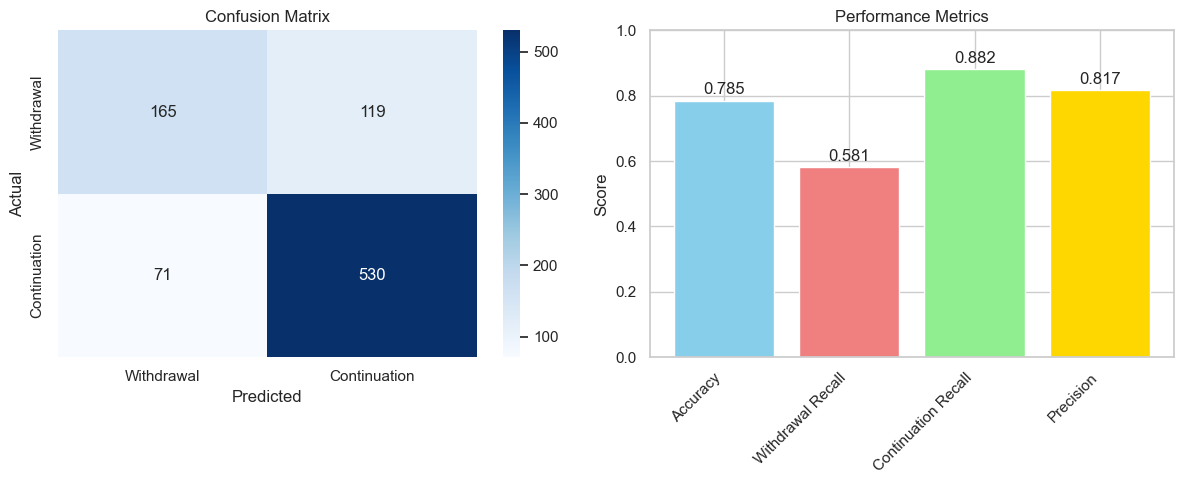

✅ k-NN Model Complete!

Best configuration: k=3, weights=distance

In [777]:
# Create visualisation of results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Withdrawal', 'Continuation'],
           yticklabels=['Withdrawal', 'Continuation'],
           ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Performance Metrics Bar Chart
metrics = ['Accuracy', 'Withdrawal Recall', 'Continuation Recall', 'Precision']
values = [accuracy, specificity, sensitivity, precision]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

bars = axes[1].bar(metrics, values, color=colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Performance Metrics')
axes[1].set_ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f'✅ k-NN Model Complete!')
print(f'Best configuration: k={grid_search.best_params_["classifier__n_neighbors"]}, '
      f'weights={grid_search.best_params_["classifier__weights"]}')